# Medical Deep Learning


## ECG Classification with ResNet and LSTM 

In [ ]:
!pip install wget
!wget https://cloud.imi.uni-luebeck.de/s/SGZiDPjny7Si6cS/download -O mdl_exercise2_utils.py

!wget https://cloud.imi.uni-luebeck.de/s/2qnRpqx9SmdwLCR/download -O featnet1.pt

!wget https://cloud.imi.uni-luebeck.de/s/B7myD39xfjMCjnS/download -O FeatNet1.py

Some necessary **imports** and **settings**:

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import mdl_exercise2_utils as mdl_e1_utils
from FeatNet1 import FeatNet1, ResBlock

# get wget for python (disable output)
!pip install -q wget >/dev/null

# settings
%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### PhysioNet/CinC Challenge



number of recordings:  8528
number of classes: 4


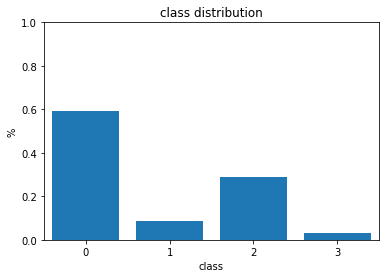

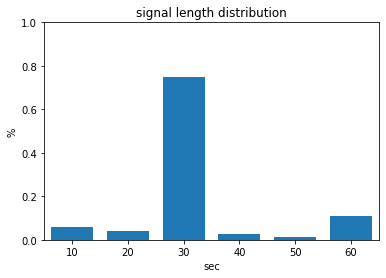

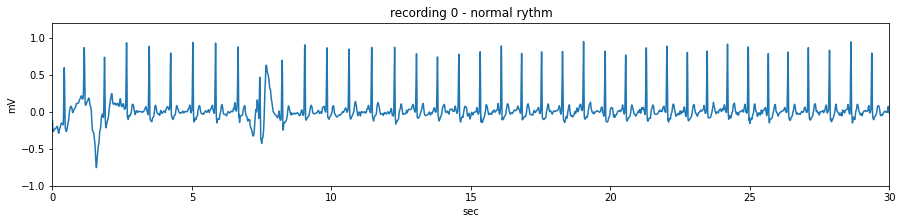

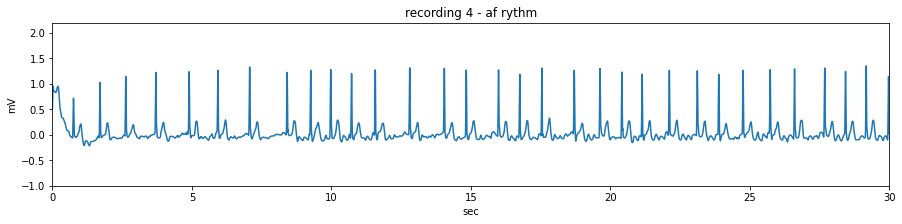

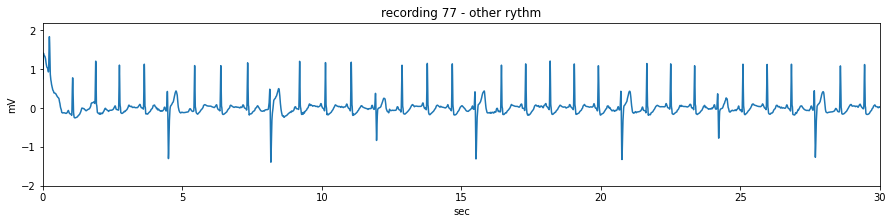

signal tensor([-154., -273., -395.,  ...,  478.,  349.,  220.])


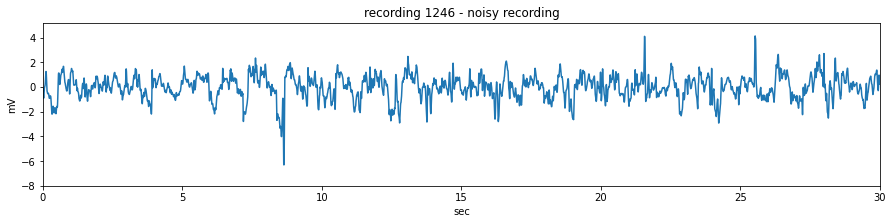

In [ ]:
# get dataset
dataset, sample_rate = mdl_e1_utils.get_physionet_dataset()

# number of recordings
num_recordings = len(dataset)
print('number of recordings: ', num_recordings)

# number of classes
num_classes = torch.unique(torch.tensor([entry['target'] for entry in dataset])).numel()
print('number of classes:', num_classes)

# class distribution
class_distribution = torch.histc(torch.tensor([entry['target'].float() for entry in dataset]), bins=num_classes)/num_recordings
plt.figure('class distribution')
plt.bar(torch.arange(num_classes), class_distribution)
plt.title('class distribution')
plt.xlabel('class')
plt.xticks(torch.arange(num_classes))
plt.xlim([-0.5, num_classes-0.5])
plt.ylabel('%')
plt.ylim([0, 1])
plt.show()

# signal length distribution
signal_length_distribution = torch.histc(torch.tensor([entry['input'].numel()/sample_rate for entry in dataset]), bins=6)/num_recordings
plt.figure('signal length distribution')
plt.bar((torch.arange(6)+1)*10, signal_length_distribution, width=7.5)
plt.title('signal length distribution')
plt.xlabel('sec')
plt.xticks((torch.arange(6)+1)*10)
plt.xlim([5, 65])
plt.ylabel('%')
plt.ylim([0, 1])
plt.show()

# plot signals (one example for each target)
signal = dataset[0]['input']
plt.figure('recording 0 - normal rythm', figsize=(15,3))
plt.plot((torch.arange(signal.numel()).float()/sample_rate).numpy(), (signal/1000).numpy())
plt.title('recording 0 - normal rythm')
plt.xlabel('sec')
plt.xlim([0, 30])
plt.ylabel('mV')
plt.ylim([-1, 1.2])
plt.show()

signal = dataset[3]['input']
plt.figure('recording 4 - af rythm', figsize=(15,3))
plt.plot((torch.arange(signal.numel()).float()/sample_rate).numpy(), (signal/1000).numpy())
plt.title('recording 4 - af rythm')
plt.xlabel('sec')
plt.xlim([0, 30])
plt.ylabel('mV')
plt.ylim([-1, 2.2])
plt.show()

signal = dataset[76]['input']
plt.figure('recording 77 - other rythm', figsize=(15,3))
plt.plot((torch.arange(signal.numel()).float()/sample_rate).numpy(), (signal/1000).numpy())
plt.title('recording 77 - other rythm')
plt.xlabel('sec')
plt.xlim([0, 30])
plt.ylabel('mV')
plt.ylim([-2, 2.2])
plt.show()

signal = dataset[1245]['input']
print("signal",signal)
plt.figure('recording 1246 - noisy recording', figsize=(15,3))
plt.plot((torch.arange(signal.numel()).float()/sample_rate).numpy(), (signal/1000).numpy())
plt.title('recording 1246 - noisy recording')
plt.xlabel('sec')
plt.xlim([0, 30])
plt.ylabel('mV')
plt.ylim([-8, 5.2])
plt.show()


### Preprocessing

The recordings in the dataset are not normalized and of variable sequence length. To use the ecg signals with our neural nets normalize each recording to have zero mean and unit variance. Further, ensure that each recording has a fixed signal length of 30 seconds. If a recording is longer than 30 seconds crop it symmetrically, if it is shorter pad the signal with zeros, again symmetrically.



In [ ]:
# normalize each recording
from math import ceil

#print("mean",signal.mean(),"std",signal.std())
for i in range(num_recordings):
  # 
  signal = dataset[i]['input']
  
  mean = torch.mean(signal, 0, keepdim=False, out=None)
  std = torch.std(signal)
  dataset[i]['input'] = (signal - mean)/std


fixed_signal_length = 30
for i in range(num_recordings):
  #TODO

  if (len(dataset[i]['input'])/sample_rate) > fixed_signal_length:
    dataset[i]['input'] = dataset[i]['input'][0:fixed_signal_length*sample_rate]
  
  if (len(dataset[i]['input'])/sample_rate) < fixed_signal_length:
    padding = (fixed_signal_length - len(dataset[i]['input'])/sample_rate)*sample_rate #TODO
    padL = int(ceil(padding // 2))
    padR = int(ceil(padding - padL))
    #print(padL,padR,padding)
   # print(len(dataset[i]['input']))
    dataset[i]['input'] = F.pad(dataset[i]['input'], (padL,padR))
    dataset[i]['input'] = dataset[i]['input'][0:fixed_signal_length*sample_rate]
  print("secs: ",(len(dataset[i]['input'])/sample_rate))

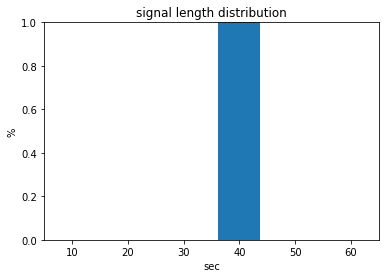

In [ ]:
# signal length distribution
signal_length_distribution = torch.histc(torch.tensor([entry['input'].numel()/sample_rate for entry in dataset]), bins=6)/num_recordings
plt.figure('signal length distribution')
plt.bar((torch.arange(6)+1)*10, signal_length_distribution, width=7.5)
plt.title('signal length distribution')
plt.xlabel('sec')
plt.xticks((torch.arange(6)+1)*10)
plt.xlim([5, 65])
plt.ylabel('%')
plt.ylim([0, 1])
plt.show()

we perform a single fold validation on a fixed train/valid set (with ratio 90:10).

In [ ]:
# for reproducibility (do not change)
torch.manual_seed(0)

# split dataset in train/valid set
ratio = 0.9
split = int(num_recordings*ratio)
perm = torch.randperm(num_recordings)
dataset_train = [dataset[i] for i in perm[:split]]
dataset_valid = [dataset[i] for i in perm[split:]]
num_recordings_train = len(dataset_train)
num_recordings_valid = len(dataset_valid)

### 7 Layer ResNet + Linear Classifier


In [ ]:
# classifier1
class Classifier1(nn.Module):
    def __init__(self):
        super(Classifier1, self).__init__()

        #TODO
        self.maxPool = torch.nn.AdaptiveMaxPool1d(1)
        self.linear = torch.nn.Linear(64, 4)

        
    def forward(self, x):
        #TODO
        mp = self.maxPool(x)
        out1 = mp.squeeze(2)

        lin = self.linear(out1)
        
        return lin

In [ ]:
# for reproducibility (do not change)
torch.manual_seed(0)

# parameters
batch_size = 32
num_epochs = 10

# models
featnet1 = torch.load('/content/featnet1.pt').cuda()
classifier1 = Classifier1().cuda()   
print('Parameter count:', mdl_e1_utils.parameter_count(featnet1) + mdl_e1_utils.parameter_count(classifier1))

print(classifier1)

# optimizer
optimizer = torch.optim.Adam(list(featnet1.parameters()) + list(classifier1.parameters()), lr=0.001)#TODO

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)#TODO

# criterion
class_distribution = torch.histc(torch.tensor([entry['target'].float() for entry in dataset]), bins=num_classes)/num_recordings
class_weights = torch.tensor([1/torch.sqrt(class_fraction*num_recordings) for class_fraction in class_distribution])#TODO
criterion = nn.CrossEntropyLoss().cuda()#TODO

# input and target
input_train = torch.stack([entry['input'] for entry in dataset_train]).cuda()
target_train = torch.cat([entry['target'] for entry in dataset_train]).cuda()
input_valid = torch.stack([entry['input'] for entry in dataset_valid]).cuda()
target_valid = torch.cat([entry['target'] for entry in dataset_valid]).cuda()

# statistics
losses_train = []
f1s_train = []
losses_valid = []
f1s_valid = []

# for num_epochs
for epoch in range(num_epochs):
  
    # train mode
    featnet1.train()
    classifier1.train()
    
    # update learning rate
    lr_scheduler.step()
    
    # random mini-batches
    batch_train = torch.randperm(num_recordings_train)
    batch_train = batch_train[(batch_train.numel() % batch_size):]
    batch_train = batch_train.view(-1, batch_size)
    
    # statistics
    running_loss = 0.0
    conf_mat = torch.zeros(num_classes, num_classes).cuda()
    
    # for each mini-batch
    for i in range(batch_train.size(0)):
        
        # mini-batch
        input = input_train[batch_train[i], :].unsqueeze(1)
        target = target_train[batch_train[i]]
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = classifier1(featnet1(input))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item()
        conf_mat += mdl_e1_utils.confusion_mat(output, target)
    
    running_loss /= batch_train.size(0)
    f1 = mdl_e1_utils.f1_score(conf_mat)
    
    losses_train.append(running_loss)
    f1s_train.append(f1)
    
    # output
    print('Epoch {} (train) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))
    
    # validate
    with torch.no_grad():
      
        # eval mode
        featnet1.eval()
        classifier1.eval()

        # random mini-batches
        batch_valid = torch.randperm(num_recordings_valid)
        batch_valid = batch_valid[(batch_valid.numel() % batch_size):]
        batch_valid = batch_valid.view(-1, batch_size)

        # statistics
        running_loss = 0.0
        conf_mat = torch.zeros(num_classes, num_classes).cuda()
        
        # for each mini-batch
        for i in range(batch_valid.size(0)):

            # mini-batch
            input = input_valid[batch_valid[i], :].unsqueeze(1)
            target = target_valid[batch_valid[i]]

            # forward
            output = classifier1(featnet1(input))
            loss = criterion(output, target)

            # statistics
            running_loss += loss.item()
            conf_mat += mdl_e1_utils.confusion_mat(output, target)

        running_loss /= batch_valid.size(0)
        f1 = mdl_e1_utils.f1_score(conf_mat)

        losses_valid.append(running_loss)
        f1s_valid.append(f1)

        # output
        print('Epoch {} (valid) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))

# best F1 score
print('Best F1 score (valid):', '{:.2f}'.format(round(max(f1s_valid), 2)))

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute o

Parameter count: 170692
Classifier1(
  (maxPool): AdaptiveMaxPool1d(output_size=1)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0 (train) -- loss: 0.5784 f1: 0.7114
Epoch 0 (valid) -- loss: 0.5773 f1: 0.7172
Epoch 1 (train) -- loss: 0.4310 f1: 0.8014
Epoch 1 (valid) -- loss: 0.5418 f1: 0.7191
Epoch 2 (train) -- loss: 0.3726 f1: 0.8332
Epoch 2 (valid) -- loss: 0.5228 f1: 0.7517
Epoch 3 (train) -- loss: 0.3254 f1: 0.8566
Epoch 3 (valid) -- loss: 0.5562 f1: 0.6998
Epoch 4 (train) -- loss: 0.2764 f1: 0.8881
Epoch 4 (valid) -- loss: 0.5295 f1: 0.7563
Epoch 5 (train) -- loss: 0.2252 f1: 0.9174
Epoch 5 (valid) -- loss: 0.5325 f1: 0.7261
Epoch 6 (train) -- loss: 0.1865 f1: 0.9288
Epoch 6 (valid) -- loss: 0.5372 f1: 0.7284
Epoch 7 (train) -- loss: 0.1537 f1: 0.9488
Epoch 7 (valid) -- loss: 0.5740 f1: 0.7466
Epoch 8 (train) -- loss: 0.1092 f1: 0.9737
Epoch 8 (valid) -- loss: 0.5551 f1: 0.7427
Epoch 9 (train) -- loss: 0.0817 f1: 0.9855
Epoch 9 (valid) -- loss: 0.5830 f1: 0.7038
Best F1 score (valid): 0.76


### 15 Layer ResNet + Linear Classifier



In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResNetBlock, self).__init__()
        
        #TODO
        self.conv1 = nn.Conv1d(in_channels,out_channels, kernel_size,2)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.convRES1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=2)
        self.bnRES1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

        self.convRES2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=floor(kernel_size/2))
        self.bnRES2 = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        #TODO
        res = self.bn1(self.conv1(x))
        a = self.convRES1(x)
        b = self.bnRES1(a)
        out1 = self.relu(b)

        c = self.convRES2(out1)
        out2 = self.bnRES2(c)

        result = res + out2

        return self.relu(result)
      
class FeatNet2(nn.Module):
    def __init__(self):
        super(FeatNet2, self).__init__()

        #TODO
        self.rsB1 = ResNetBlock(64,64,17)
        self.rsB2 = ResNetBlock(64,128,17)
        self.rsB3 = ResNetBlock(128,128,17)
        self.rsB4 = ResNetBlock(128,256,17)
        
    def forward(self, x):
        #TODO
        out1 = self.rsB1(x)
        out2 = self.rsB2(out1)
        out3 = self.rsB3(out2)
        out4 = self.rsB4(out3)
        
        return out4
      
class Classifier2(nn.Module):
    def __init__(self):
        super(Classifier2, self).__init__()

        #TODO
        self.maxPool = torch.nn.AdaptiveMaxPool1d(1)
        self.linear = torch.nn.Linear(256, 4)
        
    def forward(self, x):
        #TODO
        mp = self.maxPool(x)
        out1 = mp.squeeze(2)

        lin = self.linear(out1)
        
        return lin

In [ ]:
from math import floor
# for reproducibility (do not change)
torch.manual_seed(0)

# parameters
batch_size = 32
num_epochs = 10

# models
featnet1 = torch.load('/content/featnet1.pt').cuda()
featnet2 = FeatNet2().cuda()
classifier2 = Classifier2().cuda()
print('Parameter count:', mdl_e1_utils.parameter_count(featnet1) + mdl_e1_utils.parameter_count(featnet2) + mdl_e1_utils.parameter_count(classifier2))
print(mdl_e1_utils.parameter_count(featnet1), mdl_e1_utils.parameter_count(featnet2),mdl_e1_utils.parameter_count(classifier2))

#TODO
print(classifier2)

# optimizer
optimizer = torch.optim.Adam(list(featnet1.parameters()) + list(classifier2.parameters()) + list(featnet2.parameters()), lr=0.001)#TODO

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)#TODO

# criterion
class_distribution = torch.histc(torch.tensor([entry['target'].float() for entry in dataset]), bins=num_classes)/num_recordings
class_weights = torch.tensor([1/torch.sqrt(class_fraction*num_recordings) for class_fraction in class_distribution])#TODO
criterion = nn.CrossEntropyLoss().cuda()#TODO

# input and target
input_train = torch.stack([entry['input'] for entry in dataset_train]).cuda()
target_train = torch.cat([entry['target'] for entry in dataset_train]).cuda()
input_valid = torch.stack([entry['input'] for entry in dataset_valid]).cuda()
target_valid = torch.cat([entry['target'] for entry in dataset_valid]).cuda()

# statistics
losses_train = []
f1s_train = []
losses_valid = []
f1s_valid = []

# for num_epochs
for epoch in range(num_epochs):
  
    # train mode
    featnet1.train()
    featnet2.train()
    classifier2.train()
    
    # update learning rate
    lr_scheduler.step()
    
    # random mini-batches
    batch_train = torch.randperm(num_recordings_train)
    batch_train = batch_train[(batch_train.numel() % batch_size):]
    batch_train = batch_train.view(-1, batch_size)
    
    # statistics
    running_loss = 0.0
    conf_mat = torch.zeros(num_classes, num_classes).cuda()
    
    # for each mini-batch
    for i in range(batch_train.size(0)):
        
        # mini-batch
        input = input_train[batch_train[i], :].unsqueeze(1)
        target = target_train[batch_train[i]]
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = classifier2(featnet2(featnet1(input)))

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item()
        conf_mat += mdl_e1_utils.confusion_mat(output, target)
    
    running_loss /= batch_train.size(0)
    f1 = mdl_e1_utils.f1_score(conf_mat)
    
    losses_train.append(running_loss)
    f1s_train.append(f1)
    
    # output
    print('Epoch {} (train) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))
    
    # validate
    with torch.no_grad():
      
        # eval mode
        featnet1.eval()
        featnet2.eval()
        classifier2.eval()

        # random mini-batches
        batch_valid = torch.randperm(num_recordings_valid)
        batch_valid = batch_valid[(batch_valid.numel() % batch_size):]
        batch_valid = batch_valid.view(-1, batch_size)

        # statistics
        running_loss = 0.0
        conf_mat = torch.zeros(num_classes, num_classes).cuda()
        
        # for each mini-batch
        for i in range(batch_valid.size(0)):

            # mini-batch
            input = input_valid[batch_valid[i], :].unsqueeze(1)
            target = target_valid[batch_valid[i]]

            # forward
            output = classifier2(featnet2(featnet1(input)))
            loss = criterion(output, target)

            # statistics
            running_loss += loss.item()
            conf_mat += mdl_e1_utils.confusion_mat(output, target)

        running_loss /= batch_valid.size(0)
        f1 = mdl_e1_utils.f1_score(conf_mat)

        losses_valid.append(running_loss)
        f1s_valid.append(f1)

        # output
        print('Epoch {} (valid) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))

# best F1 score
print('Best F1 score (valid):', '{:.2f}'.format(round(max(f1s_valid), 2)))

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute o

Parameter count: 4006404
170432 3834944 1028
Classifier2(
  (maxPool): AdaptiveMaxPool1d(output_size=1)
  (linear): Linear(in_features=256, out_features=4, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0 (train) -- loss: 0.6478 f1: 0.6512
Epoch 0 (valid) -- loss: 0.4845 f1: 0.7006
Epoch 1 (train) -- loss: 0.4691 f1: 0.7605
Epoch 1 (valid) -- loss: 0.4940 f1: 0.7522
Epoch 2 (train) -- loss: 0.4217 f1: 0.7996
Epoch 2 (valid) -- loss: 0.5098 f1: 0.6210
Epoch 3 (train) -- loss: 0.3735 f1: 0.8325
Epoch 3 (valid) -- loss: 0.4160 f1: 0.8129
Epoch 4 (train) -- loss: 0.3281 f1: 0.8555
Epoch 4 (valid) -- loss: 0.4555 f1: 0.8072
Epoch 5 (train) -- loss: 0.3067 f1: 0.8649
Epoch 5 (valid) -- loss: 0.5199 f1: 0.7743
Epoch 6 (train) -- loss: 0.2489 f1: 0.8991
Epoch 6 (valid) -- loss: 0.4635 f1: 0.8071
Epoch 7 (train) -- loss: 0.2110 f1: 0.9133
Epoch 7 (valid) -- loss: 0.4642 f1: 0.7972
Epoch 8 (train) -- loss: 0.1517 f1: 0.9433
Epoch 8 (valid) -- loss: 0.5871 f1: 0.7660
Epoch 9 (train) -- loss: 0.1236 f1: 0.9570
Epoch 9 (valid) -- loss: 0.6003 f1: 0.7336
Best F1 score (valid): 0.81


### 15 Layer ResNet + LSTM + Linear Classifier

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        
        #TODO
        self.cell1 = nn.LSTMCell(256, 64)
        self.cell2 = nn.LSTMCell(64, 64)
        
    def forward(self, x):
        #TODO
        for i in range(x.size()[2]):
          c1 = self.cell1(x[:,:,i])
          out = self.cell2(c1[0])[0]
            
        return out
      
class Classifier3(nn.Module):
    def __init__(self):
        super(Classifier3, self).__init__()

        self.linear = torch.nn.Linear(64, 4)
        
    def forward(self, x):
        #TODO
        lin = self.linear(x)
        
        return lin

In [ ]:
# for reproducibility (do not change)
torch.manual_seed(0)

# parameters
batch_size = 32
num_epochs = 15

# models
lstmnet = LSTMNet().cuda()
classifier3 = Classifier3().cuda()
print('Parameter count:', mdl_e1_utils.parameter_count(featnet1) + mdl_e1_utils.parameter_count(featnet2) + mdl_e1_utils.parameter_count(lstmnet) + mdl_e1_utils.parameter_count(classifier3))

#TODO
print(classifier3)

# optimizer
optimizer = torch.optim.Adam(list(featnet1.parameters()) + list(classifier3.parameters()) + list(featnet2.parameters()) + list(lstmnet.parameters()), lr=0.001)#TODO

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)#TODO

# criterion
class_distribution = torch.histc(torch.tensor([entry['target'].float() for entry in dataset]), bins=num_classes)/num_recordings
class_weights = torch.tensor([1/torch.sqrt(class_fraction*num_recordings) for class_fraction in class_distribution])#TODO
criterion = nn.CrossEntropyLoss().cuda()#TODO

# input and target
input_train = torch.stack([entry['input'] for entry in dataset_train]).cuda()
target_train = torch.cat([entry['target'] for entry in dataset_train]).cuda()
input_valid = torch.stack([entry['input'] for entry in dataset_valid]).cuda()
target_valid = torch.cat([entry['target'] for entry in dataset_valid]).cuda()

# statistics
losses_train = []
f1s_train = []
losses_valid = []
f1s_valid = []

# for num_epochs
for epoch in range(num_epochs):
  
    # train mode
    lstmnet.train()
    featnet1.train()
    featnet2.train()
    classifier3.train()
    
    # update learning rate
    lr_scheduler.step()
    
    # random mini-batches
    batch_train = torch.randperm(num_recordings_train)
    batch_train = batch_train[(batch_train.numel() % batch_size):]
    batch_train = batch_train.view(-1, batch_size)
    
    # statistics
    running_loss = 0.0
    conf_mat = torch.zeros(num_classes, num_classes).cuda()
    
    # for each mini-batch
    for i in range(batch_train.size(0)):
        
        # mini-batch
        input = input_train[batch_train[i], :].unsqueeze(1)
        target = target_train[batch_train[i]]
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = classifier3(lstmnet(featnet2(featnet1(input))))

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item()
        conf_mat += mdl_e1_utils.confusion_mat(output, target)
    
    running_loss /= batch_train.size(0)
    f1 = mdl_e1_utils.f1_score(conf_mat)
    
    losses_train.append(running_loss)
    f1s_train.append(f1)
    
    # output
    print('Epoch {} (train) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))
    
    # validate
    with torch.no_grad():
      
        # eval mode
        featnet1.eval()
        featnet2.eval()
        classifier3.eval()
        lstmnet.eval()

        # random mini-batches
        batch_valid = torch.randperm(num_recordings_valid)
        batch_valid = batch_valid[(batch_valid.numel() % batch_size):]
        batch_valid = batch_valid.view(-1, batch_size)

        # statistics
        running_loss = 0.0
        conf_mat = torch.zeros(num_classes, num_classes).cuda()
        
        # for each mini-batch
        for i in range(batch_valid.size(0)):

            # mini-batch
            input = input_valid[batch_valid[i], :].unsqueeze(1)
            target = target_valid[batch_valid[i]]

            # forward
            output = classifier3(lstmnet(featnet2(featnet1(input))))
            loss = criterion(output, target)

            # statistics
            running_loss += loss.item()
            conf_mat += mdl_e1_utils.confusion_mat(output, target)

        running_loss /= batch_valid.size(0)
        f1 = mdl_e1_utils.f1_score(conf_mat)

        losses_valid.append(running_loss)
        f1s_valid.append(f1)

        # output
        print('Epoch {} (valid) -- loss: {:.4f} f1: {:.4f}'.format(epoch, running_loss, f1))

# best F1 score
print('Best F1 score (valid):', '{:.2f}'.format(round(max(f1s_valid), 2)))

Parameter count: 4121348
Classifier3(
  (linear): Linear(in_features=64, out_features=4, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0 (train) -- loss: 0.7622 f1: 0.4813
Epoch 0 (valid) -- loss: 0.7158 f1: 0.5382
Epoch 1 (train) -- loss: 0.6215 f1: 0.6570
Epoch 1 (valid) -- loss: 0.5818 f1: 0.7068
Epoch 2 (train) -- loss: 0.5646 f1: 0.7185
Epoch 2 (valid) -- loss: 0.5303 f1: 0.7279
Epoch 3 (train) -- loss: 0.5250 f1: 0.7458
Epoch 3 (valid) -- loss: 0.5114 f1: 0.7732
Epoch 4 (train) -- loss: 0.4977 f1: 0.7688
Epoch 4 (valid) -- loss: 0.5635 f1: 0.6956
Epoch 5 (train) -- loss: 0.4692 f1: 0.7862
Epoch 5 (valid) -- loss: 0.5202 f1: 0.7515
Epoch 6 (train) -- loss: 0.4342 f1: 0.8131
Epoch 6 (valid) -- loss: 0.5201 f1: 0.7677
Epoch 7 (train) -- loss: 0.3930 f1: 0.8279
Epoch 7 (valid) -- loss: 0.6509 f1: 0.6759
Epoch 8 (train) -- loss: 0.3572 f1: 0.8550
Epoch 8 (valid) -- loss: 0.5552 f1: 0.7417
Epoch 9 (train) -- loss: 0.3293 f1: 0.8658
Epoch 9 (valid) -- loss: 0.5610 f1: 0.7542
Epoch 10 (train) -- loss: 0.2840 f1: 0.8895
Epoch 10 (valid) -- loss: 0.6085 f1: 0.7542
Epoch 11 (train) -- loss: 0.2498 f1: 0.9099
Epoch 11